# Rayleigh-normal distribution functions

## Step 1: Definitions

The continuous fidelity (or the Bhattacharyya coefficient) for continuous probability distributions $p$ and $q$ on $\mathbb{R}$ is defined by (https://arxiv.org/pdf/1306.4166.pdf):
\begin{align}
\mathcal{F}(p, q) := \int_{\mathbb{R}} \sqrt{p(x) q(x)} dx
\end{align}

For any $\mu \in \mathbb{R}$ and $\nu > 0$, let $\Phi_{\mu, \nu}$ and $\phi_{\mu, \nu}$ denote the cdf and pdf of the Gaussian distribution of mean $\mu$ and variance $\nu$.  In particular, we denote $\Phi$ and $\phi$ as the cdf and pdf the standard normal distribution.

### Definition 1

The Rayleigh-normal distribution function $Z_\nu$ on $\mathbb{R}$ is defined by:
\begin{align}
Z_\nu := \begin{cases}
1 - \sup_A \mathcal{F}\left(\frac{dA}{dx}, \phi_{\mu, \nu}\right)^2, & \nu > 0 \\
\Phi, & \nu = 0
\end{cases}
\end{align}
where $A : \mathbb{R} \to [0, 1]$ runs over continuously differentiable monotone increasing functions satisfying $\Phi \leq A \leq 1$ on the right hand side.

It can be shown that:
1. The Rayleigh-normal distribution function $Z_\nu$ can be shown to be right-continuous at $\nu = 0$.

We denote the cdf of the Rayleigh distribution with scale parameter $\sigma > 0$ by:
\begin{align}
    R_{\sigma}(x) = \begin{cases}
    1 - e^{- \frac{x^2}{2 \sigma^2}}, & x > 0 \\
    0, & x \leq 0
    \end{cases}.
\end{align}

### Lemma 2

When $0 < \nu < 1$, the equation with respect to $x$
\begin{align}
    \frac{\phi(x)}{\phi_{\mu, \nu}(x)} = \frac{1 - \Phi(x)}{1 - \Phi_{\mu, \nu}(x)}
\end{align}
has a unique solution $\beta_{\mu, \nu}$.

It can be shown that:
1. $\beta_{\mu, \nu} < \frac{\mu}{1 - \nu}$
1. $\beta_{\mu, \nu}$ is differentiable and monotonically increasing with respect to $\mu$

### Lemma 3

When $\nu > 1$, the equation with respect to $x$
\begin{align}
    \frac{\phi(x)}{\phi_{\mu, \nu}(x)} = \frac{\Phi(x)}{\Phi_{\mu, \nu}(x)}
\end{align}
has a unique solution $\alpha_{\mu, \nu}$.

It can be shown that:
1. $\alpha_{\mu, \nu} > \frac{\mu}{1 - \nu}$
1. $\alpha_{\mu, \nu}$ is differentiable and monotonically decreasing with respect to $\mu$

### Theorem 7 (Explicit form of $Z_\nu$)

For $\nu \geq 0$, we have:
\begin{align}
    Z_\nu(\mu)
    = \begin{cases}
    \Phi(\mu), & \nu = 0 \\
    1 - (\sqrt{1 - \Phi(\beta_{\mu, \nu})} \sqrt{1 - \Phi_{\mu, \nu}(\beta_{\mu, \nu})} + I_{\mu, \nu}(\beta_{\mu, \nu}))^2, & 0 < \nu < 1 \\
    R_{\sqrt{2}}(\mu), & \nu = 1 \\
    1 - (\sqrt{\Phi(\alpha_{\mu, \nu}) \Phi_{\mu, \nu}(\alpha_{\mu, \nu})} + I_{\mu, \nu}(\infty)- I_{\mu, \nu}(\alpha_{\mu, \nu}))^2, & \nu > 1
    \end{cases}
\end{align}

where
\begin{align}
I_{\mu, \nu}(x) := \sqrt{\frac{2 \sqrt{\nu}}{1 + \nu}} e^{- \frac{\mu^2}{4(1 + \nu)}} \Phi_{\frac{\mu}{1 + \nu}, \frac{2\nu}{1 + \nu}}(x)
\end{align}
and
\begin{align}
I_{\mu, \nu}(\infty) := \sqrt{\frac{2 \sqrt{\nu}}{1 + \nu}} e^{- \frac{\mu^2}{4(1 + \nu)}}.
\end{align}

## Step 2: Calculations

### Import modules

In [9]:
from scipy.stats import norm, rayleigh, rv_continuous
from scipy.optimize import fsolve
from math import sqrt, exp
import numpy as np

### Define functions

1. $\alpha, \beta$

In [10]:
def equation(x, mean, var, mode):
    sd = sqrt(var)
    if mode == 'alpha':
        return norm.pdf(x) / norm.pdf(x, mean, sd) - norm.cdf(x) / norm.cdf(x, mean, sd)
    else:
        # mode == 'beta'
        return norm.pdf(x) / norm.pdf(x, mean, sd) - norm.sf(x) / norm.sf(x, mean, sd)
    
def solve(mean, var, mode):
    initial_guess = mean / (1 - var)
    result = fsolve(equation, initial_guess, (mean, var, mode))
    return result[0]

# Assumes var > 1
def alpha(mean, var):
    if var <= 1:
        raise ValueError("Requires: var > 1")
    return solve(mean, var, 'alpha')

# Assumes 0 < var < 1
def beta(mean, var):
    if var <= 0 or var >= 1:
        raise ValueError("Requires: 0 < var < 1")
    return solve(mean, var, 'beta')

2. $I_{\mu, \nu}(x)$

In [11]:
def I(x, mean, var):
    sd = sqrt(var)
    head = sqrt(2 * sd / (1 + var))
    exponent = - mean**2 / (4 * (1 + var))
    coeff = head * exp(exponent)
    
    if x == 'inf':
        return coeff
    else:
        return coeff * norm.cdf(x, loc=mean / (1 + var), scale=sqrt(2 * var / (1 + var)))

3. $Z_{\nu}(\mu)$

In [12]:
def Z(mean, var):
    if var < 0:
        raise ValueError("Requires: var >= 0")
        
    if var == 0.0:
        return norm.cdf(mean)
    elif var > 0 and var < 1:
        b = beta(mean, var)
        sd = sqrt(var)
        return 1 - (sqrt(norm.sf(b)) * sqrt(norm.sf(b, mean, sd)) + I(b, mean, var))**2
    elif var == 1:
        return rayleigh.cdf(mean, scale=sqrt(2))
    else:
        # var > 1
        a = alpha(mean, var)
        sd = sqrt(var)
        return 1 - (sqrt(norm.cdf(a)) * sqrt(norm.cdf(a, mean, sd)) + I('inf', mean, var) - I(a, mean, var))**2

### Define a new distrbution object

In [13]:
class rayleigh_norm(rv_continuous):
    '''Rayleigh-normal distribution'''
    def _cdf(self, x, var):
        return Z(x, var)
    
    def _argcheck(self, *args):
        """Default check for correct values on args and keywords.
        Returns condition array of 1's where arguments are correct and
         0's where they are not.
        """
        cond = 1
        for arg in args:
            cond = np.logical_and(cond, (np.asarray(arg) > -np.inf))
        return cond

In [15]:
rn = rayleigh_norm()
rn.ppf(0.01, var=0.0)
rn.ppf(0.99, var=0.0)

2.3263478740408448

## Step 3: Plots

### Import modules

In [26]:
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
import pdb

/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/brianlui/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/brianlui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  app.launch_new_instance()


Text(0.5, 1.0, 'Rayleigh-normal distribution functions')

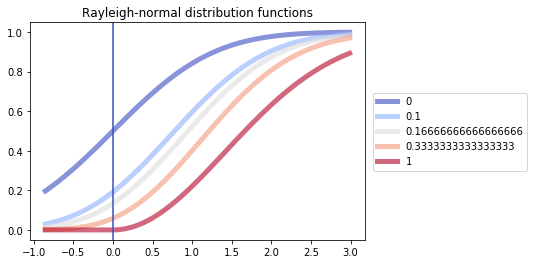

In [38]:
fig, ax = plt.subplots(1, 1)

np.random.seed(205)

vars = [0, 1/10, 1/6, 1/3, 1]
x = np.linspace(rn.ppf(0.03, 0.1), rn.ppf(0.99, 0.1), 100)
cmap = plt.cm.coolwarm
rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, len(vars))))

lines = []
for var in vars:
    cdf = np.array([rn.cdf(x_index, var) for x_index in x])
    line = ax.plot(x, cdf, '-', lw=5, alpha=0.6, label='var = {}'.format(var))
    lines.append(line)

ax.legend(lines, labels=[str(var) for var in vars], loc='upper right', bbox_to_anchor=(1.5, 0.7))
plt.axvline(x=0)
plt.title('Rayleigh-normal distribution functions')